### This is a script for casting shadow at any direction. By specifying the digital surface model and the sun position (sun elevation and sun azimuth angles).

You can try to use differnet sun positions and generate different shadow maps

In [9]:
def shadowingfunctionglobalradiation(a, azimuth, altitude, scale):
    import numpy as np
    
    #%This m.file calculates shadows on a DEM
    #% conversion
    degrees = np.pi/180.
    if azimuth == 0.0:
        azimuth = 0.000000000001
    
    azimuth = np.dot(azimuth, degrees)
    altitude = np.dot(altitude, degrees)
    #% measure the size of the image
    sizex = a.shape[0]
    sizey = a.shape[1]
    
    #% initialise parameters
    f = a
    dx = 0.
    dy = 0.
    dz = 0.
    temp = np.zeros((sizex, sizey))
    index = 1.
    
    #% other loop parameters
    amaxvalue = a.max()
    pibyfour = np.pi/4.
    threetimespibyfour = 3.*pibyfour
    fivetimespibyfour = 5.*pibyfour
    seventimespibyfour = 7.*pibyfour
    sinazimuth = np.sin(azimuth)
    cosazimuth = np.cos(azimuth)
    tanazimuth = np.tan(azimuth)
    signsinazimuth = np.sign(sinazimuth)
    signcosazimuth = np.sign(cosazimuth)
    dssin = np.abs((1./sinazimuth))
    dscos = np.abs((1./cosazimuth))
    tanaltitudebyscale = np.tan(altitude) / scale
    
    #% main loop
    while (amaxvalue >= dz and np.abs(dx) < sizex and np.abs(dy) < sizey):
        if (pibyfour <= azimuth and azimuth < threetimespibyfour or fivetimespibyfour <= azimuth and azimuth < seventimespibyfour):
            dy = signsinazimuth * index
            dx = -1. * signcosazimuth * np.abs(np.round(index / tanazimuth))
            ds = dssin
        else:
            dy = signsinazimuth * np.abs(np.round(index * tanazimuth))
            dx = -1. * signcosazimuth * index
            ds = dscos
        
        #% note: dx and dy represent absolute values while ds is an incremental value
        dz = ds *index * tanaltitudebyscale
        temp[0:sizex, 0:sizey] = 0.
        absdx = np.abs(dx)
        absdy = np.abs(dy)
        xc1 = (dx+absdx)/2.+1.
        xc2 = sizex+(dx-absdx)/2.
        yc1 = (dy+absdy)/2.+1.
        yc2 = sizey+(dy-absdy)/2.
        xp1 = -((dx-absdx)/2.)+1.
        xp2 = sizex-(dx+absdx)/2.
        yp1 = -((dy-absdy)/2.)+1.
        yp2 = sizey-(dy+absdy)/2.
        temp[int(xp1)-1:int(xp2), int(yp1)-1:int(yp2)] = a[int(xc1)-1:int(xc2), int(yc1)-1:int(yc2)]-dz
        # f = np.maximum(f, temp)  # bad performance in python3. Replaced with fmax
        f = np.fmax(f, temp)
        index += 1.
        
    f = f-a
    f = np.logical_not(f)
    sh = np.double(f)
    
    return sh

In [10]:
def saverasternd(gdal_data, filename, raster):
    rows = gdal_data.RasterYSize
    cols = gdal_data.RasterXSize
    
    outDs = gdal.GetDriverByName("GTiff").Create(filename, cols, rows, int(1), GDT_Float32)
    outBand = outDs.GetRasterBand(1)
    
    # write the data
    outBand.WriteArray(raster, 0, 0)
    # flush data to disk, set the NoData value and calculate stats
    outBand.FlushCache()
    # outBand.SetNoDataValue(-9999)
    
    # georeference the image and set the projection
    outDs.SetGeoTransform(gdal_data.GetGeoTransform())
    outDs.SetProjection(gdal_data.GetProjection())


In [5]:
!pip install pysolar

In [11]:
from pysolar.solar import *
import datetime
# from datetime import datetime
from pytz import timezone


#tzone = datetime.timezone.utc
tzone = timezone('US/Eastern')
# tzone = timezone('Asia/Shanghai')

latitude, longitude = 39.98764435284786, -75.15994171691848

# daylight saving
date = datetime.datetime(2021, 4, 3, 10, 41, 27, 130320, tzinfo=tzone)

altitude = get_altitude(latitude, longitude, date)
azimuth = get_azimuth(latitude, longitude, date)


In [12]:
import time
import os, os.path
from osgeo import gdal
from osgeo.gdalconst import *
import os, os.path
import numpy as np
import rasterio
from matplotlib import pyplot as plt


dsmfile = 'row22-col22.tif'


with rasterio.open(dsmfile) as dsmlayer:
    dsmimg = dsmlayer.read(1)

gdal_dsm = gdal.Open(dsmfile)
dsm = gdal_dsm.ReadAsArray().astype(np.float)#dsm
geotransform = gdal_dsm.GetGeoTransform()
scale = 1 / geotransform[1]


# azimuth = 200
# altitude = 40

sh = shadowingfunctionglobalradiation(dsmimg, azimuth, altitude, scale)


shadowMap = '200-40.tif'
saverasternd(gdal_dsm, shadowMap, sh)


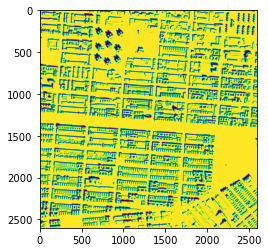

In [13]:
plt.imshow(sh)